In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import numpy as np
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executer.memory", "8g")
    .getOrCreate()
)

22/09/13 15:08:30 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.17.134.39 instead (on interface eth0)
22/09/13 15:08:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/13 15:08:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sdf = spark.read.parquet("../data/curated/full_data/")
sdf.count()

13614675

In [4]:
sdf.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- SA2_code: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- consumer_id: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- mean_total_income: integer (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: double (nullable = true)



In [5]:
clean_sdf = sdf.withColumn('dollar_value', round(F.col('dollar_value'),2))\
    .where(F.col('dollar_value') > 0)\
    .withColumn('log(cost)', log(F.col('dollar_value')))
    

In [6]:
sbs.set(rc={'figure.figsize':(11.7,8.27)})
sbs.set_style('darkgrid')
sbs.set(font_scale=1.3)

In [7]:
revenue_e = clean_sdf.where(F.col('revenue_level') == 'e').select('dollar_value').toPandas()

In [9]:
clean_sdf.where(F.col('revenue_level') == 'e').select('dollar_value').describe()

summary,dollar_value
count,120108
mean,205.81212950011658
stddev,399.06297035824383
min,0.01
max,13008.66


Text(0.5, 0, 'Dollar Value')

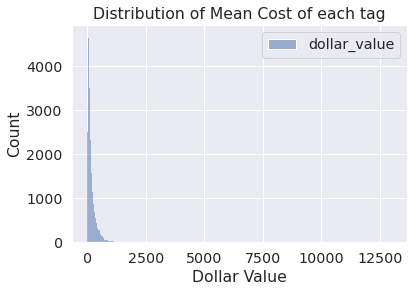

In [10]:
fig = sbs.histplot(revenue_e)
fig.set_title("Distribution of Mean Cost of each tag")
fig.set_xlabel('Dollar Value')

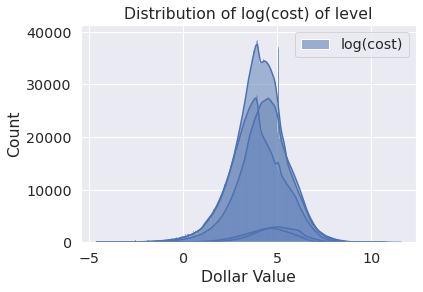

In [11]:
col = ['e', 'd', 'c', 'b', 'a']
for level in col:
    revenue = clean_sdf.where(F.col('revenue_level') == level).select('log(cost)').toPandas()
    fig = sbs.histplot(revenue, kde = True)
    fig.set_title("Distribution of log(cost) of level")
    fig.set_xlabel('Dollar Value')
    

Text(0.5, 0.98, 'Boxplot for cost of level')

findfont: Font family ['New Times Roman'] not found. Falling back to DejaVu Sans.


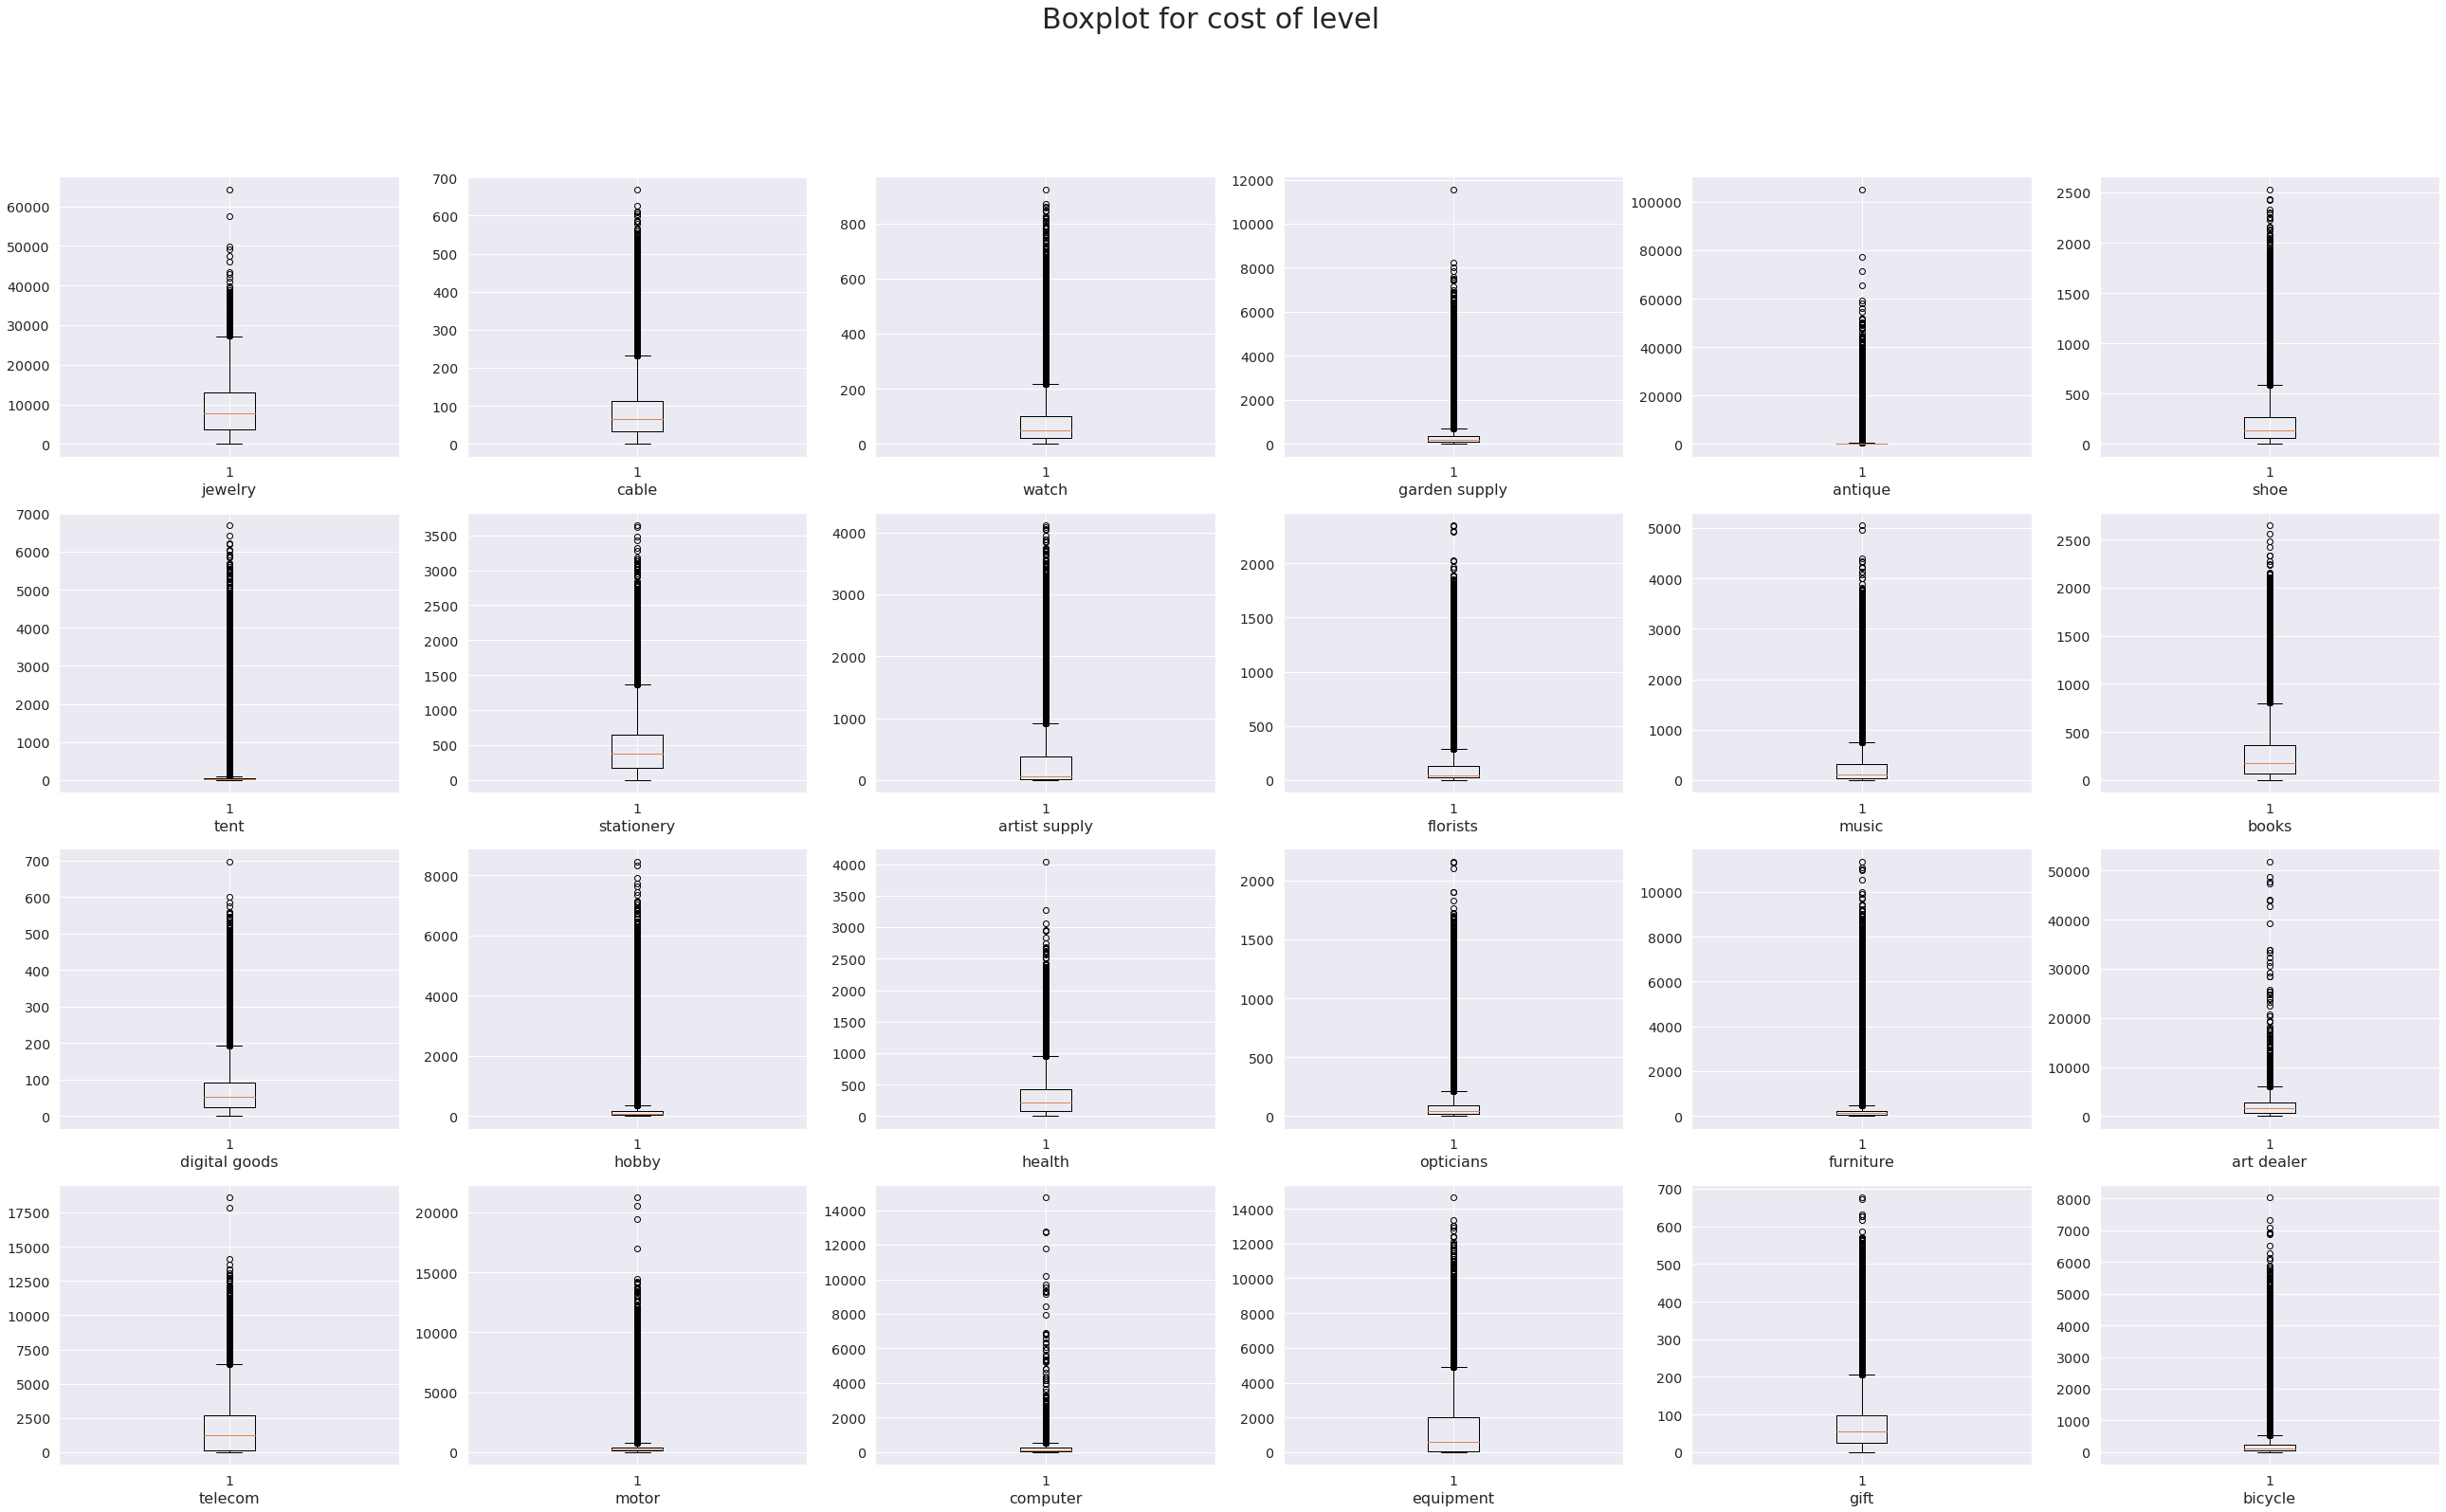

In [12]:
tag = clean_sdf.select('tags').distinct().toPandas()['tags']
fig, axs = plt.subplots(4, 6, figsize=(45,25))
for i in range(4):
    for j in range(6):
        revenue = clean_sdf.where(F.col('tags') == tag[6*i + j]).select('dollar_value').toPandas()
        axs[i][j].boxplot(revenue['dollar_value'])
        axs[i][j].set_xlabel(tag[6*i + j], size = 16, font = 'New Times Roman')
fig.suptitle("Boxplot for cost of level", fontsize=30)


Text(0.5, 0.98, 'Boxplot for log(cost) of level')

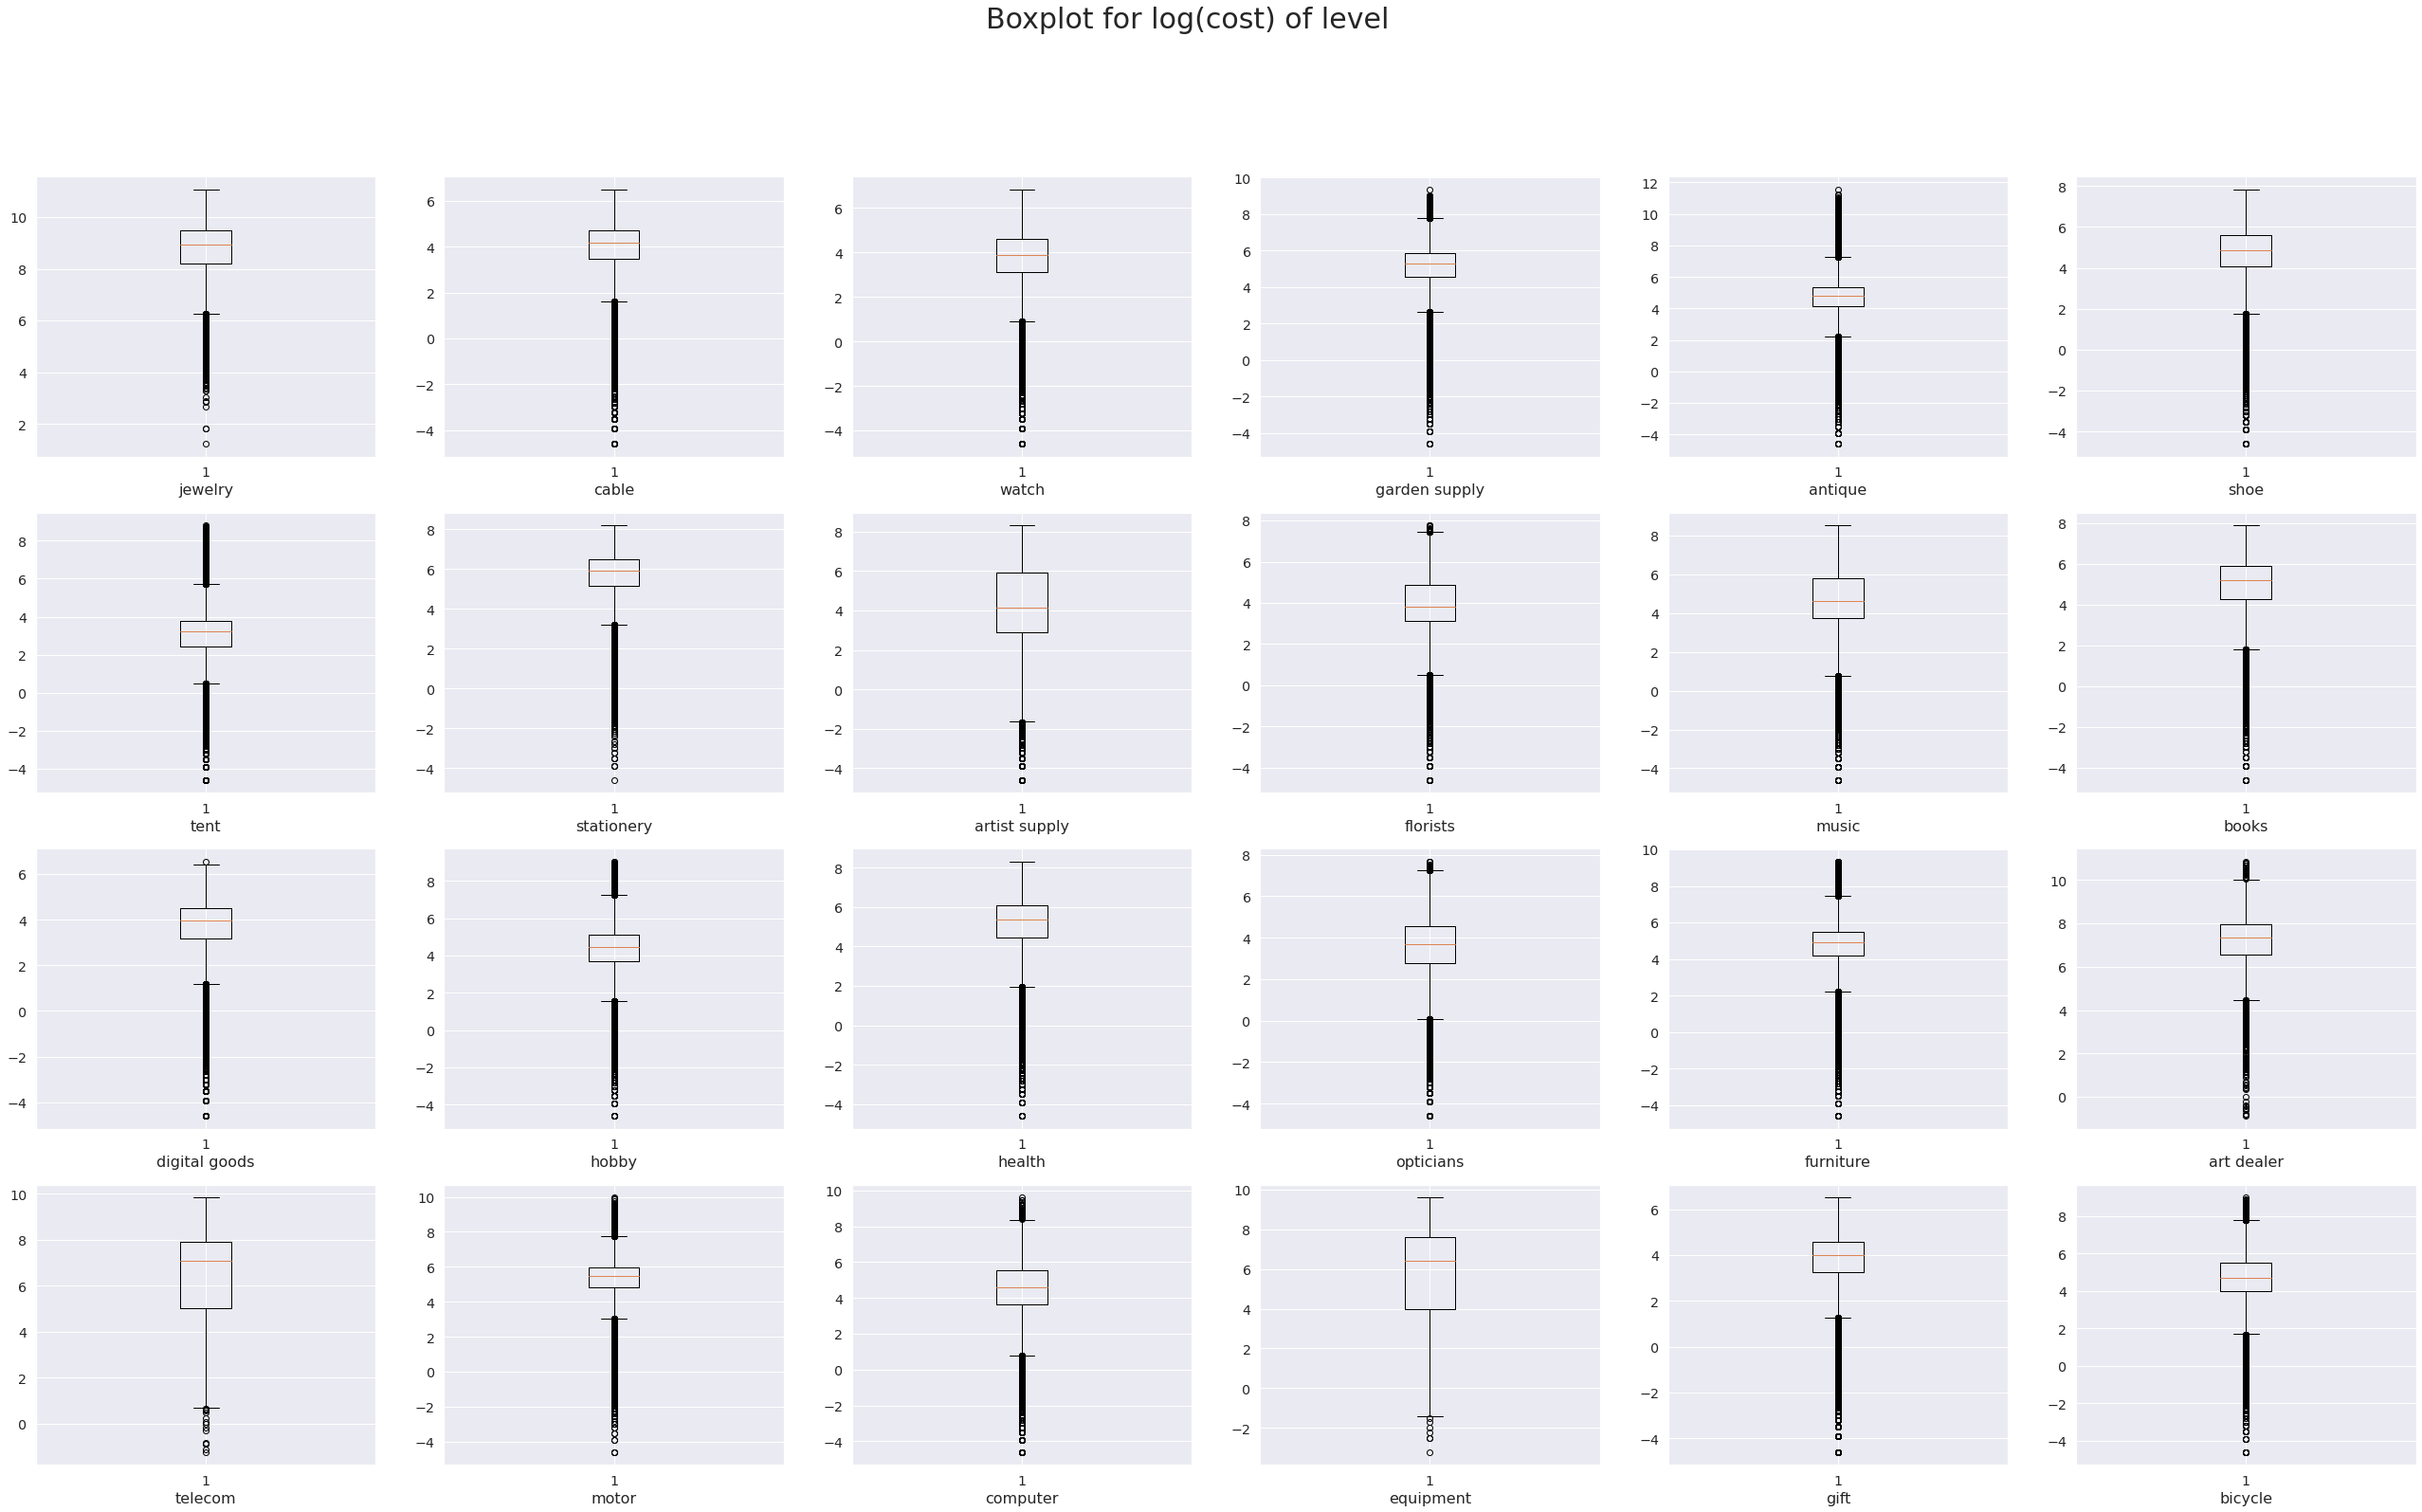

In [13]:
tag = clean_sdf.select('tags').distinct().toPandas()['tags']
fig, axs = plt.subplots(4, 6, figsize=(45,25))
for i in range(4):
    for j in range(6):
        revenue = clean_sdf.where(F.col('tags') == tag[6*i + j]).select('log(cost)').toPandas()
        axs[i][j].boxplot(revenue['log(cost)'])
        axs[i][j].set_xlabel(tag[6*i + j], size = 16, font = 'New Times Roman')
fig.suptitle("Boxplot for log(cost) of level", fontsize=30)

Text(0.5, 0.98, 'Boxplot for cost of tags')

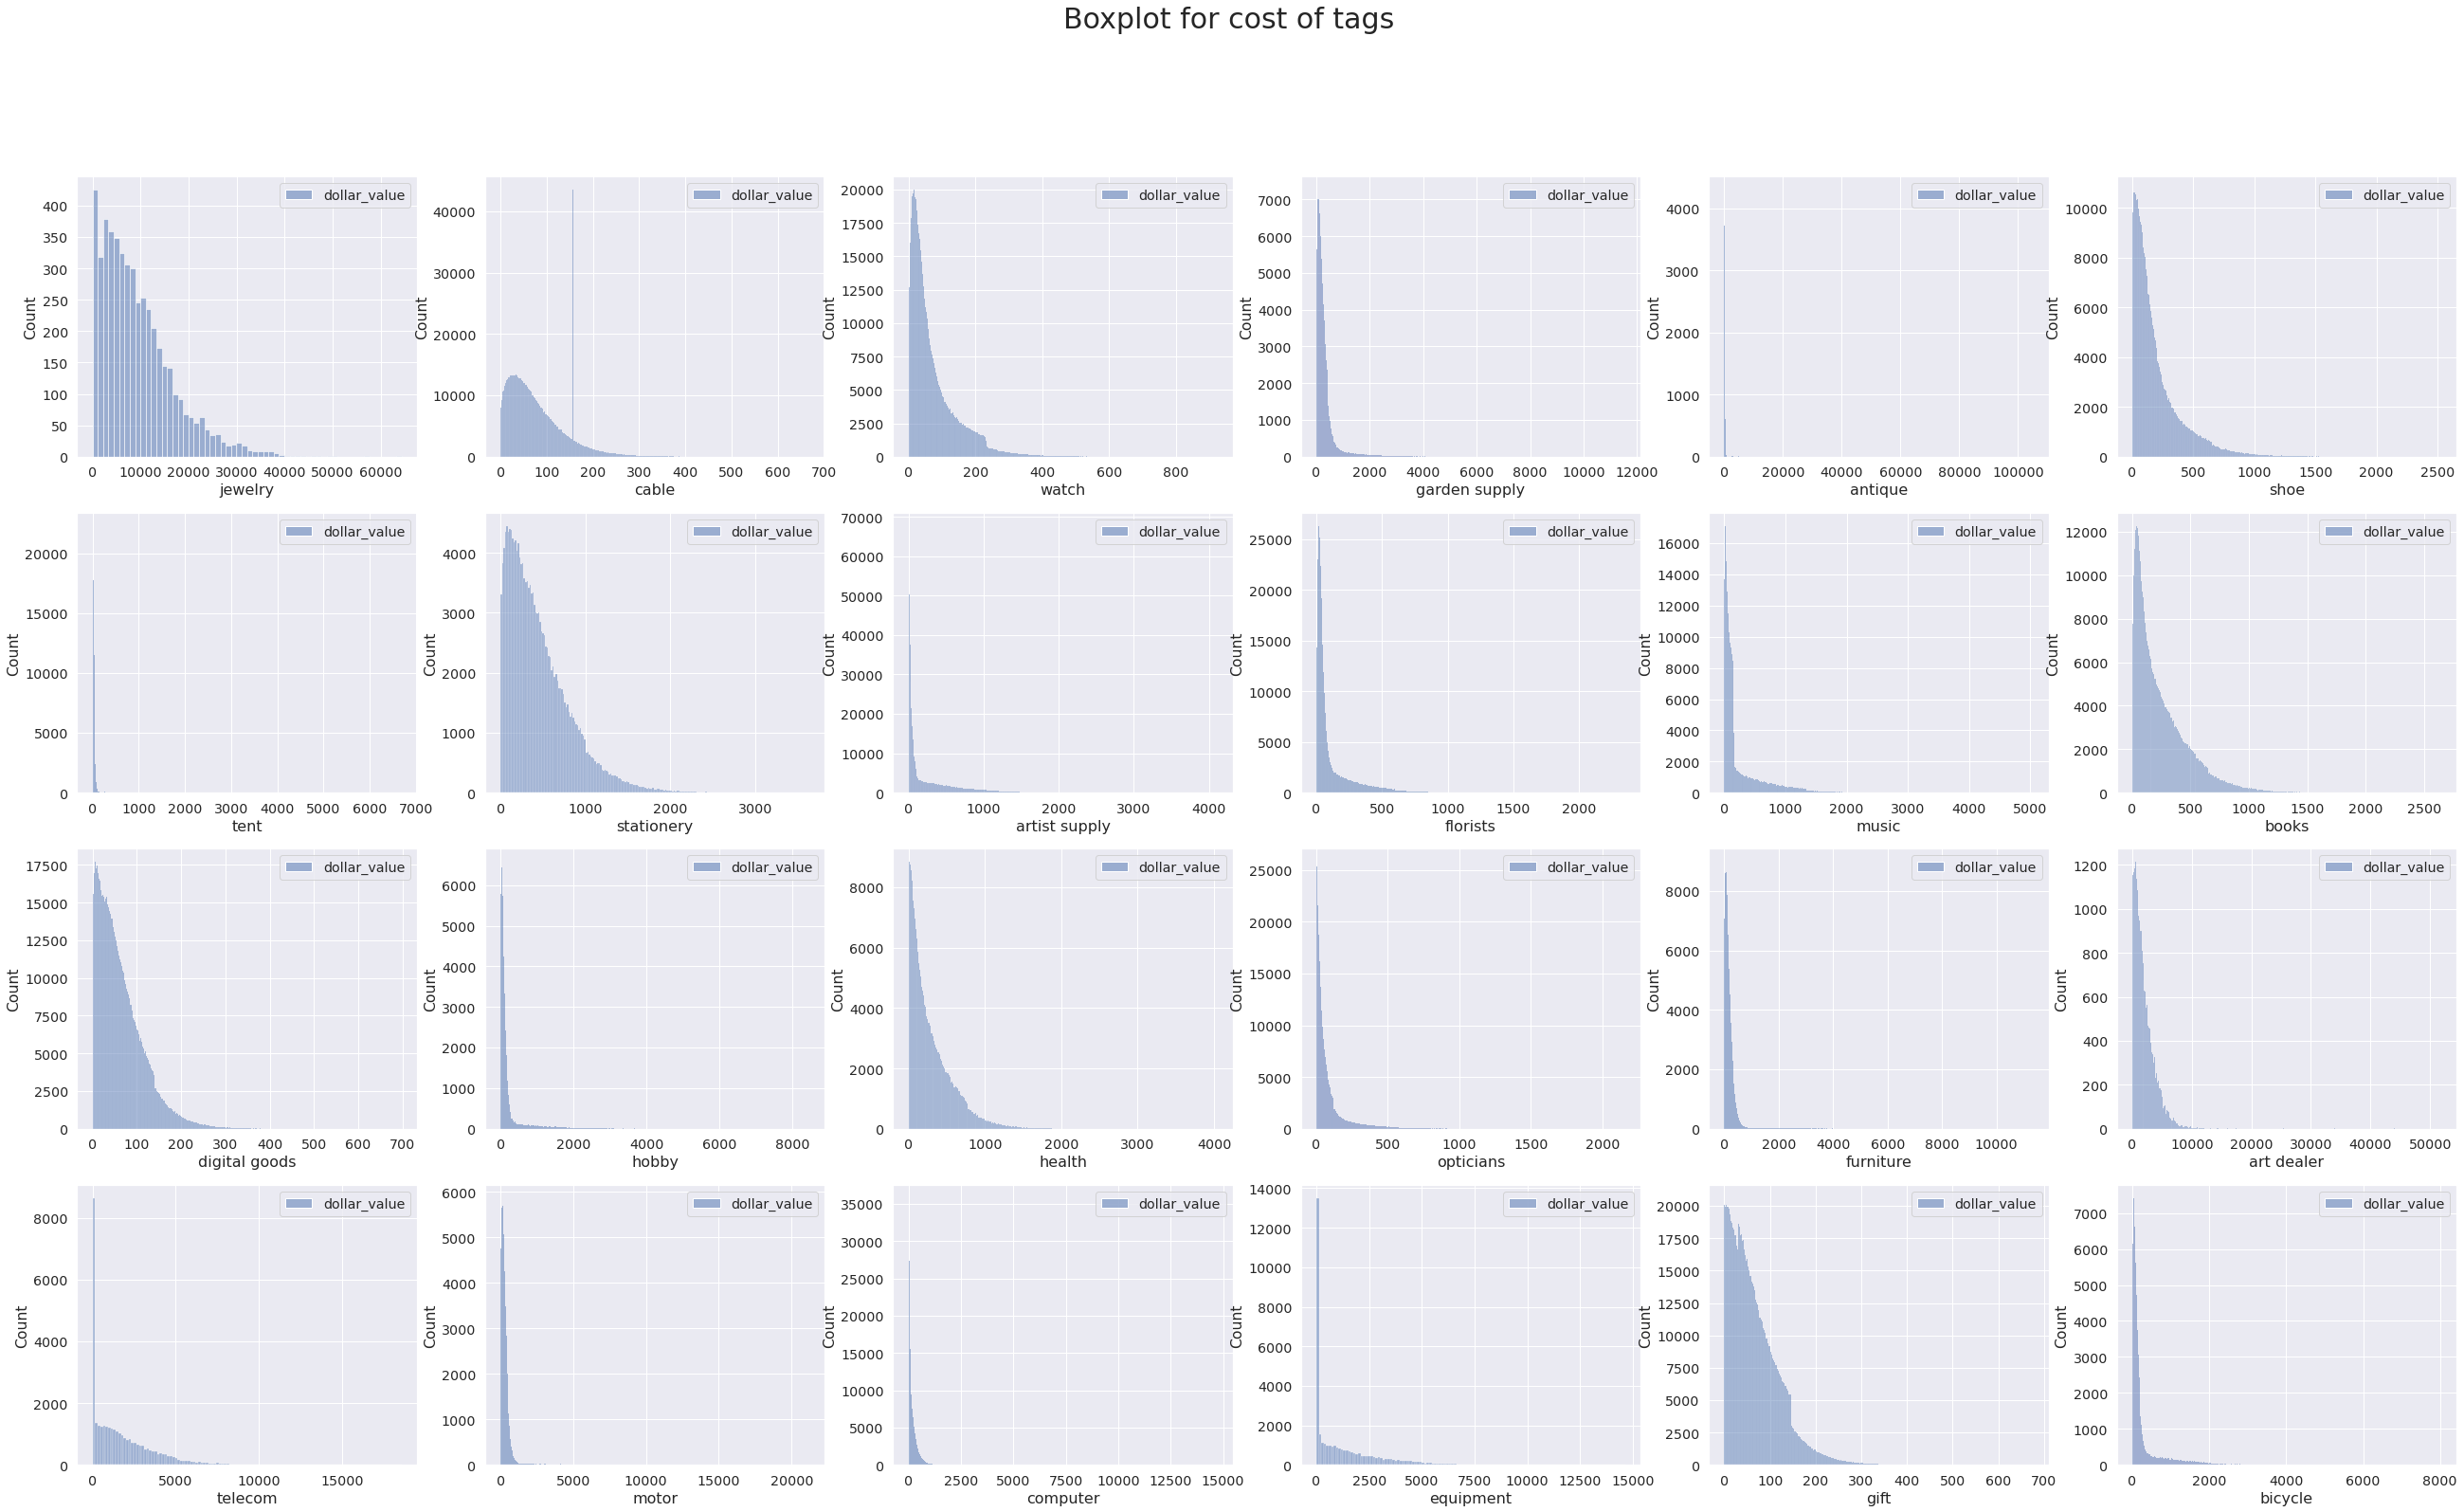

In [14]:
tag = clean_sdf.select('tags').distinct().toPandas()['tags']
fig, axs = plt.subplots(4, 6, figsize=(45,25))
for i in range(4):
    for j in range(6):
        revenue = clean_sdf.where(F.col('tags') == tag[6*i + j]).select('dollar_value').toPandas()
        sbs.histplot(ax=axs[i][j], data = revenue)
        axs[i][j].set_xlabel(tag[6*i + j], size = 16, font = 'New Times Roman')
fig.suptitle("Boxplot for cost of tags", fontsize=30)


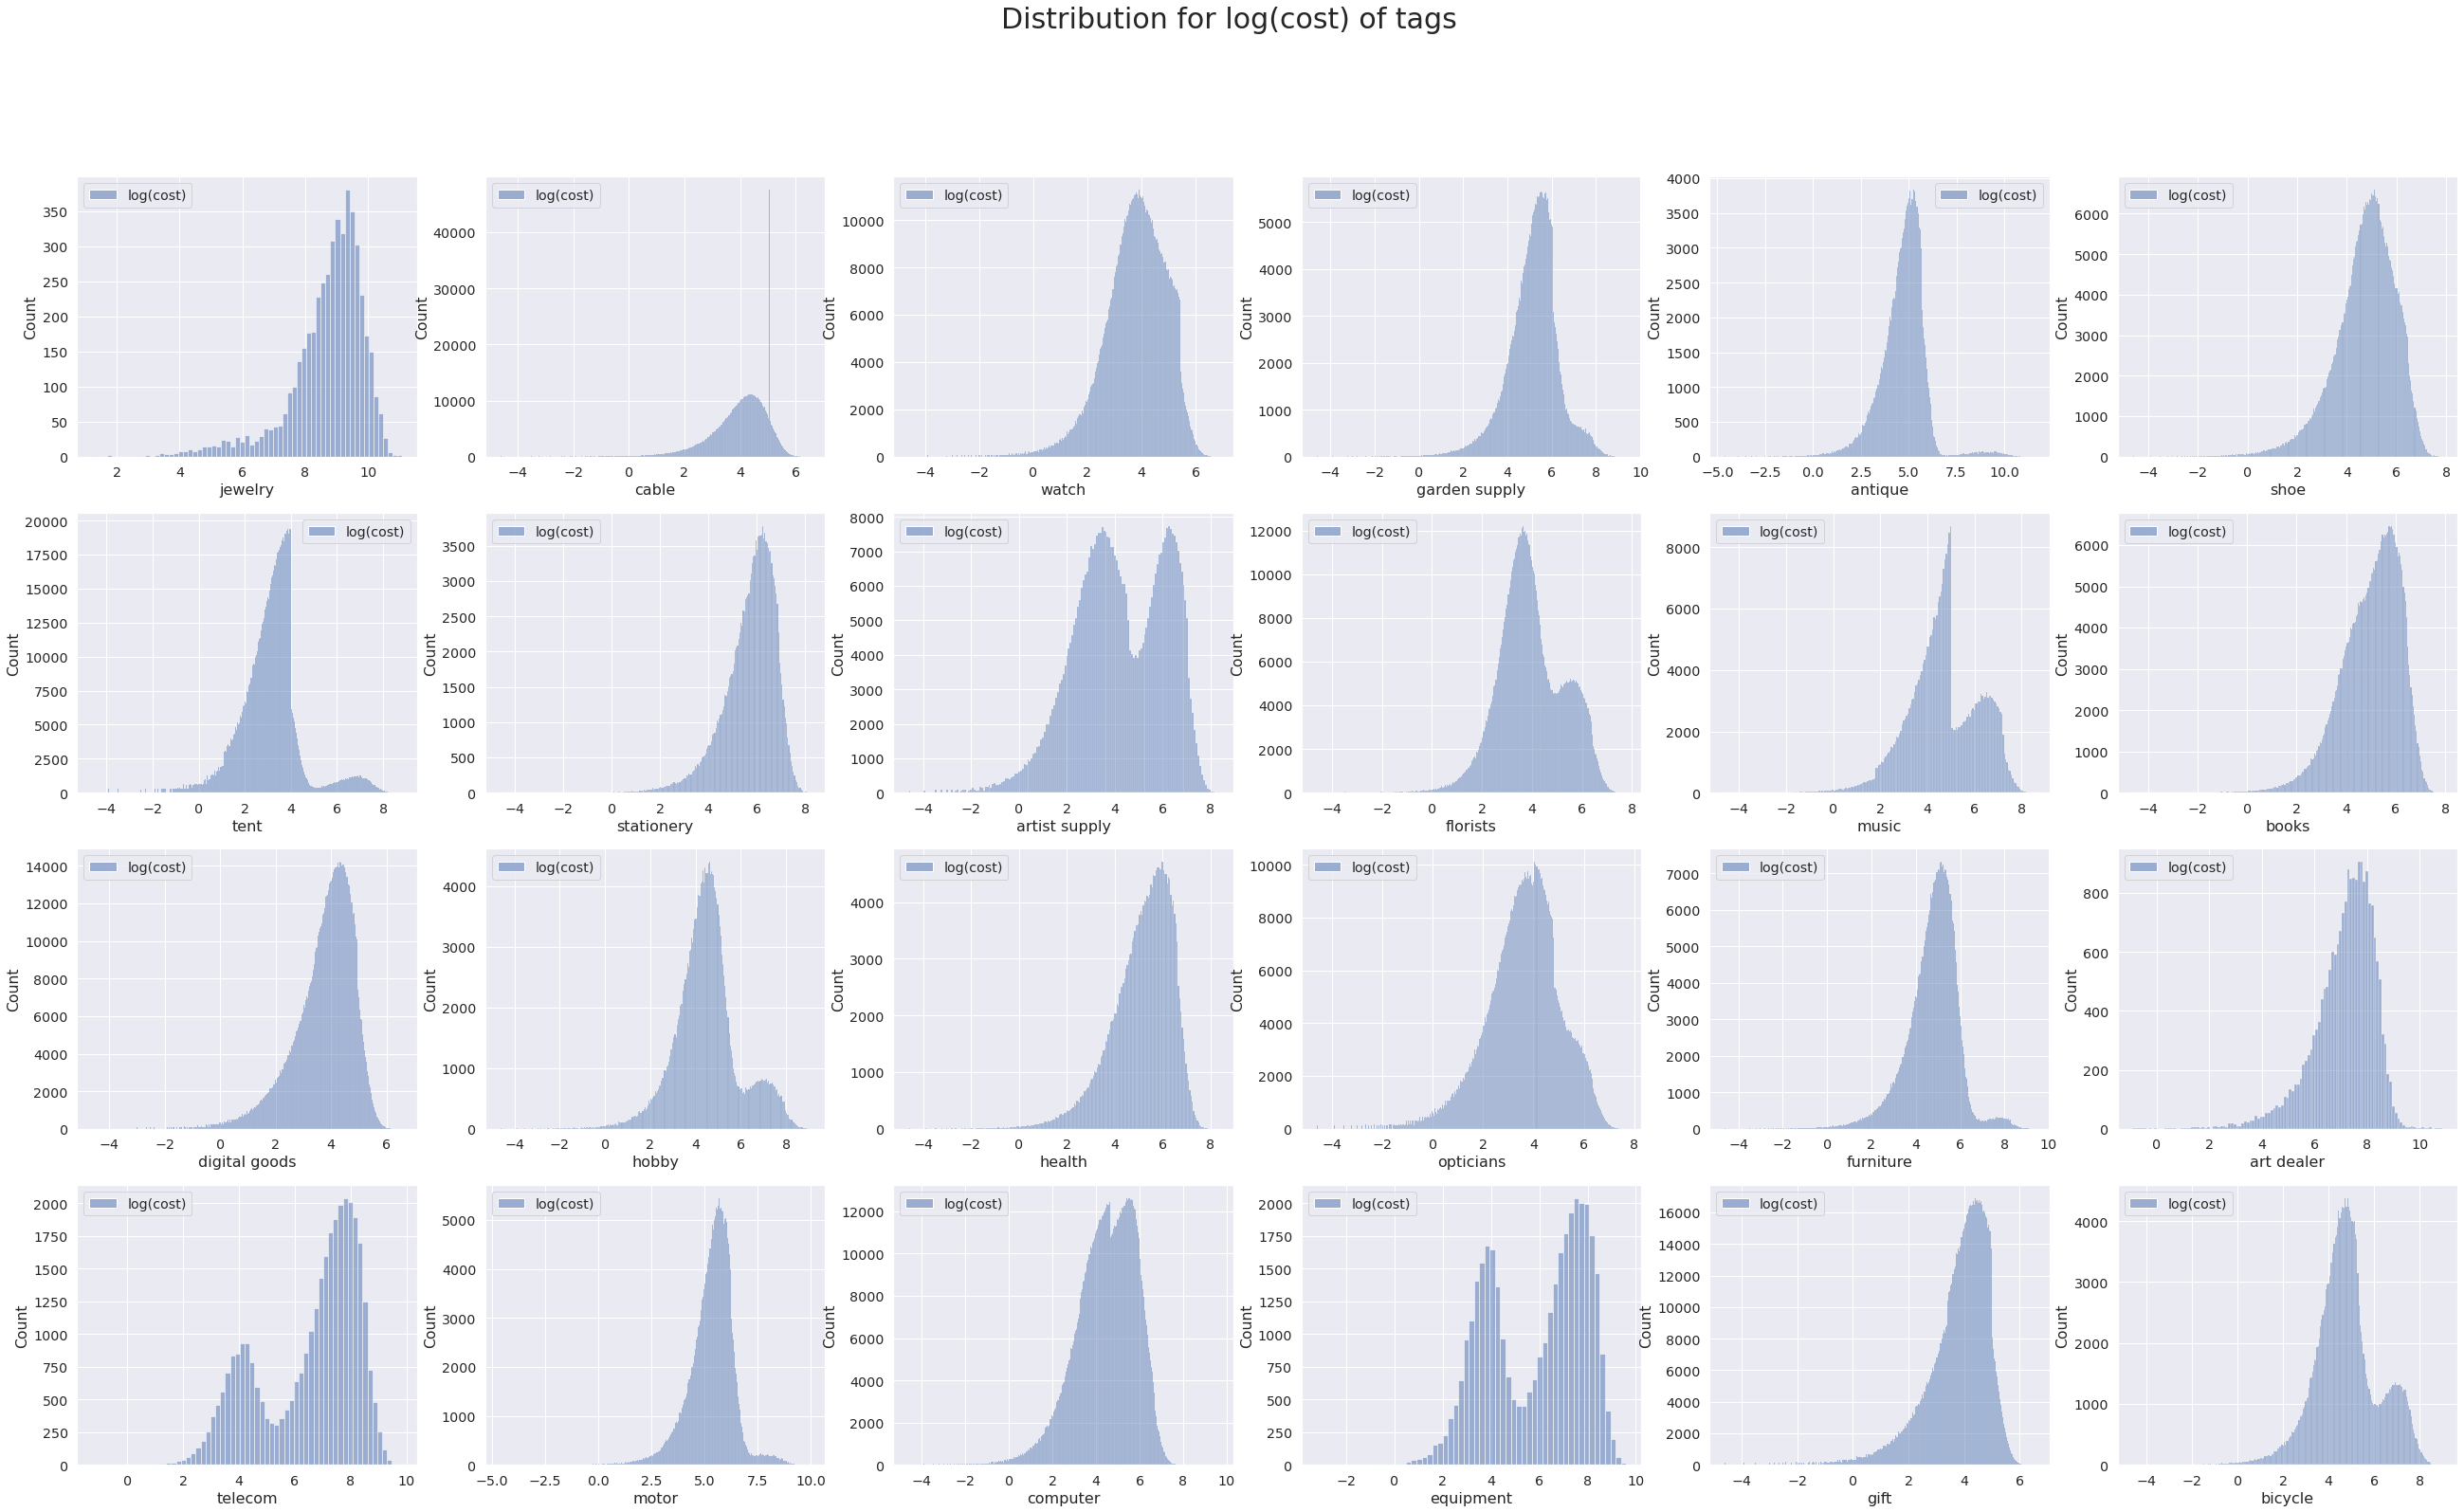

In [15]:
tag = clean_sdf.select('tags').distinct().toPandas()['tags']
fig, axs = plt.subplots(4, 6, figsize=(45,25))
for i in range(4):
    for j in range(6):
        revenue = clean_sdf.where(F.col('tags') == tag[6*i + j]).select('log(cost)').toPandas()
        sbs.histplot(ax=axs[i][j], data = revenue)
        axs[i][j].set_xlabel(tag[6*i + j], size = 16, font = 'New Times Roman')
fig.suptitle("Distribution for log(cost) of tags", fontsize=30)
fig = fig.get_figure()
fig.savefig('../plots/Distribution for log(cost) of tags.png')

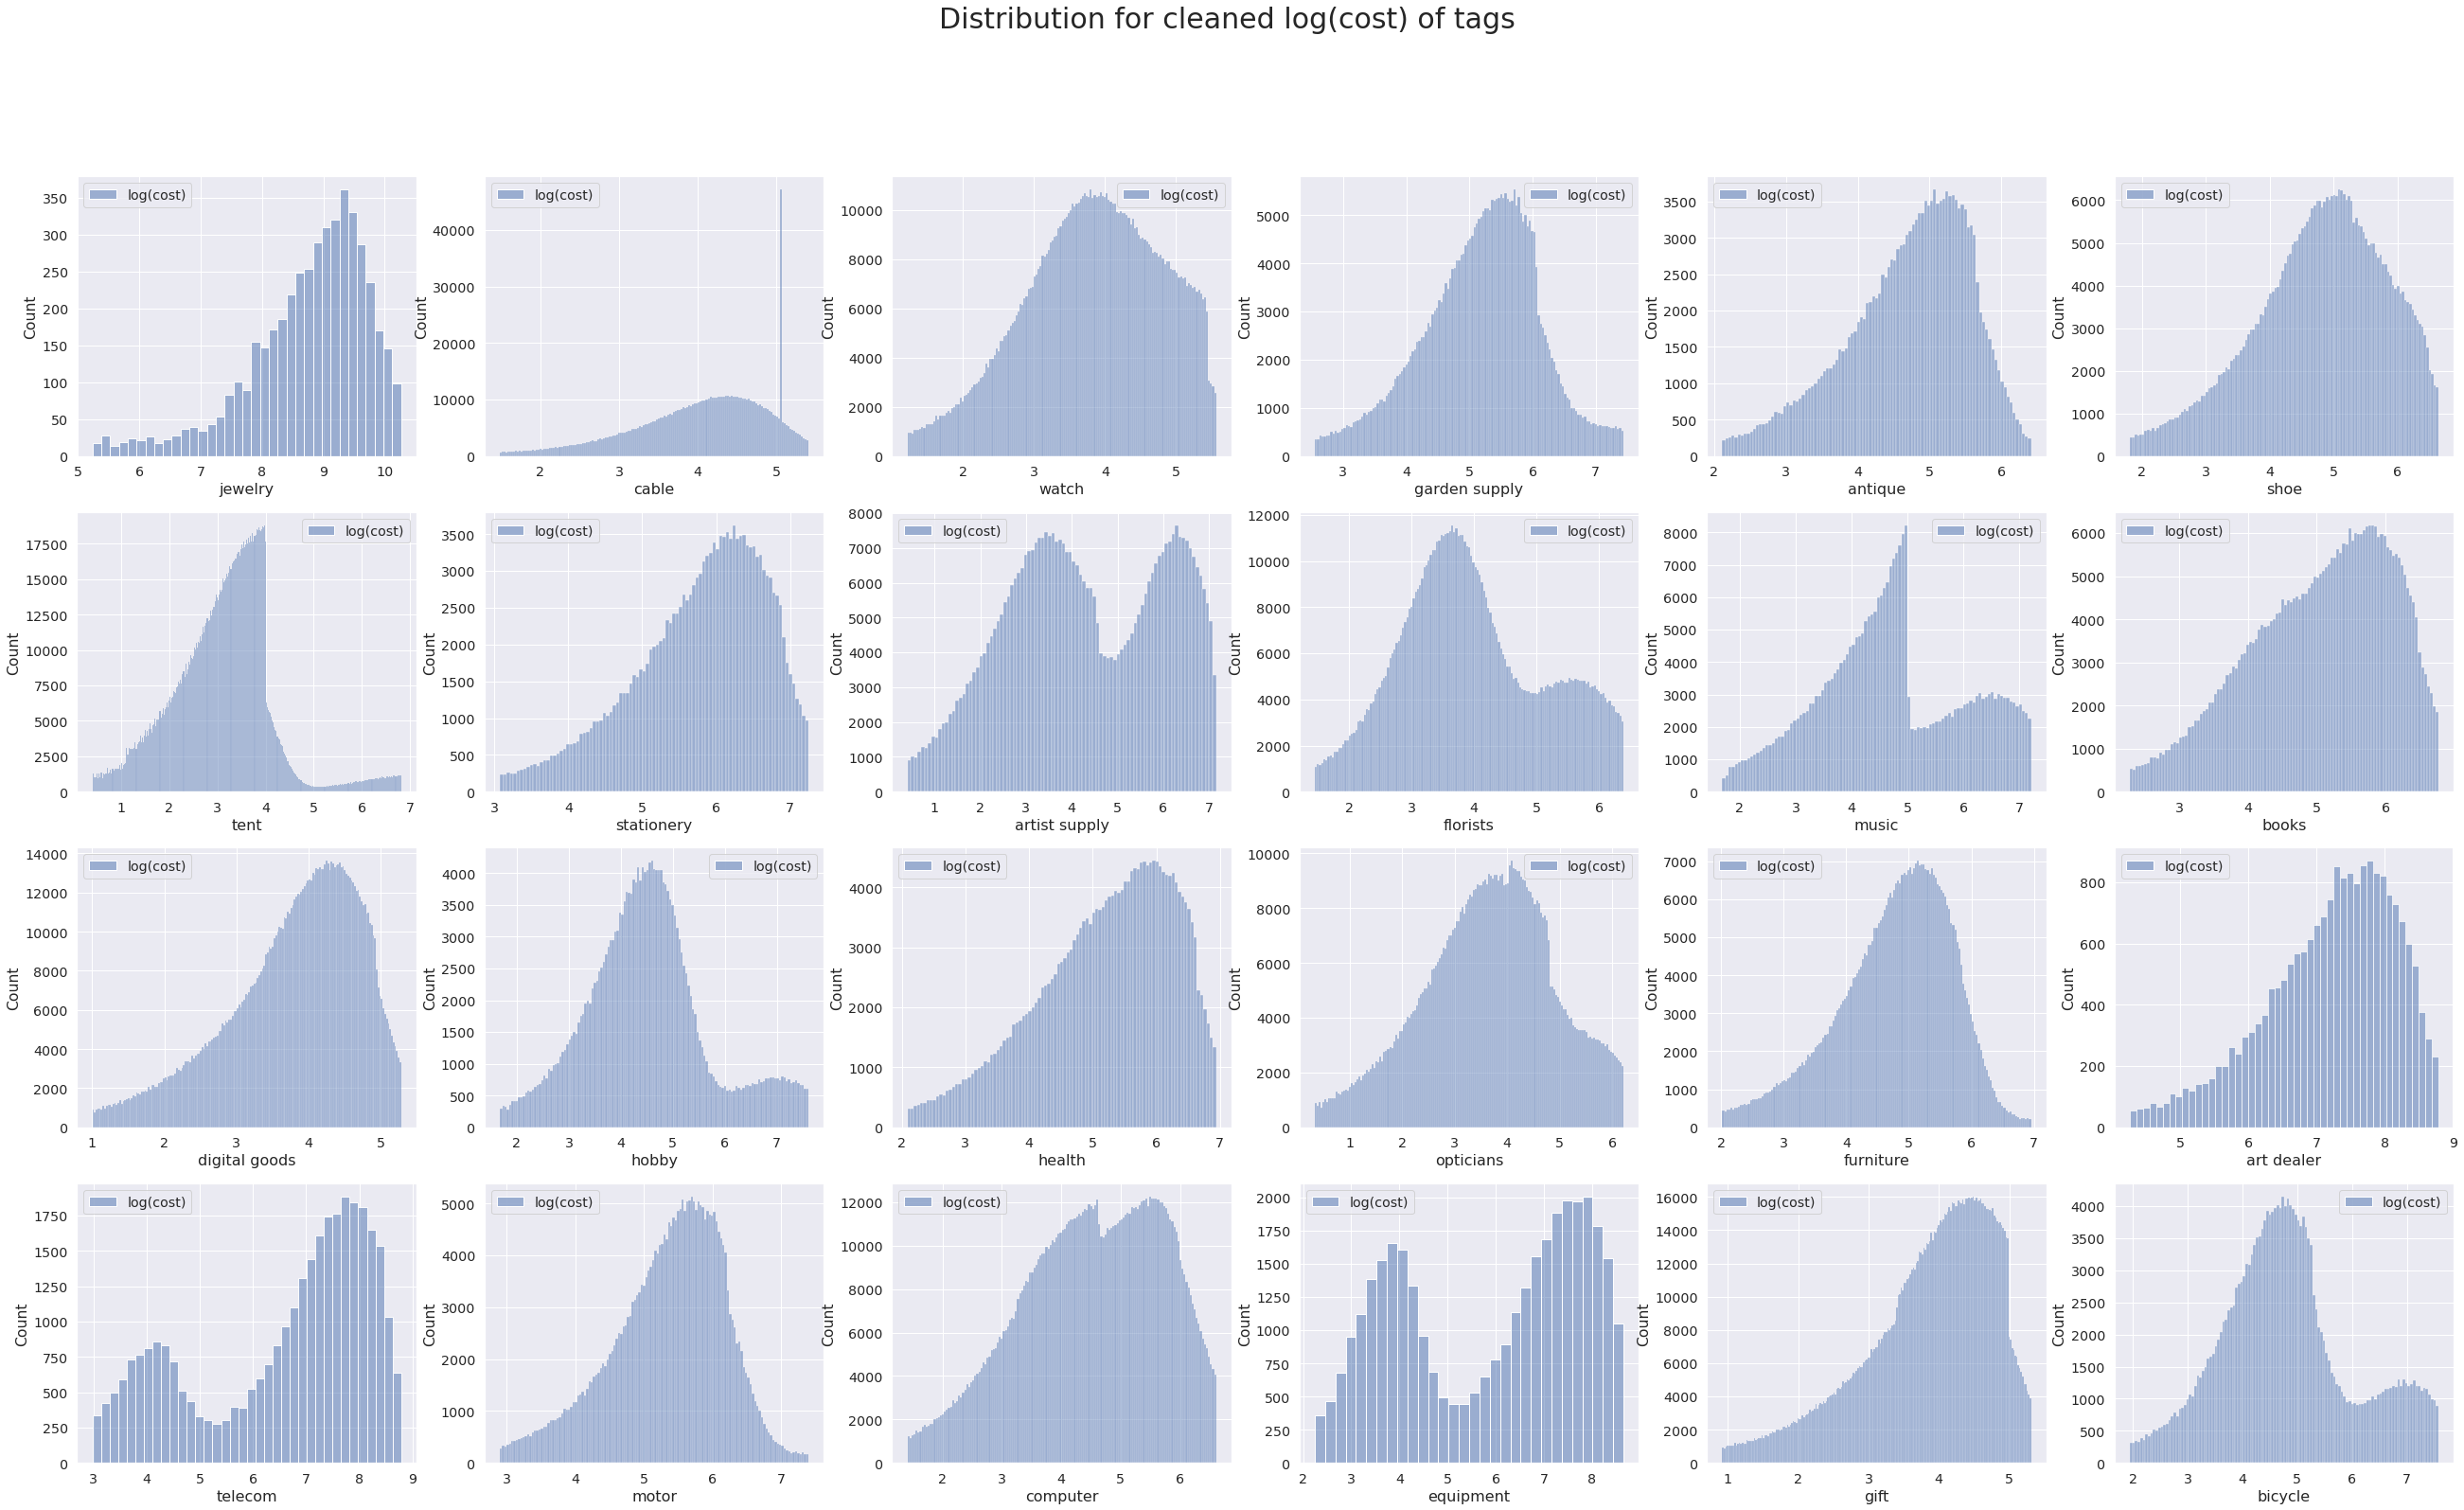

22/09/13 18:24:08 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 172106 ms exceeds timeout 120000 ms
22/09/13 18:24:08 WARN SparkContext: Killing executors is not supported by current scheduler.


In [16]:
tag = clean_sdf.select('tags').distinct().toPandas()['tags']
fig, axs = plt.subplots(4, 6, figsize=(45,25))
for i in range(4):
    for j in range(6):
        revenue = clean_sdf.where(F.col('tags') == tag[6*i + j]).select('log(cost)').toPandas()
        lb =revenue['log(cost)'].quantile(0.025)
        ub =revenue['log(cost)'].quantile(0.975)
        revenue_cleaned = revenue.loc[(revenue['log(cost)'] < ub) & (revenue['log(cost)'] > lb)]
        sbs.histplot(ax=axs[i][j], data = revenue_cleaned)
        axs[i][j].set_xlabel(tag[6*i + j], size = 16, font = 'New Times Roman')
fig.suptitle("Distribution for cleaned log(cost) of tags", fontsize=30)
fig = fig.get_figure()
fig.savefig('../plots/Distribution for cleaned log(cost) of tags.png')
    